In [74]:

!pip install seaborn matplotlib pandas scikit-learn



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [75]:
import pandas as pd
from functools import reduce
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR




In [76]:
if os.path.exists("../rawdata/ship_df.csv"):
    ship_df = pd.read_csv("../rawdata/ship_df.csv")
else:
    file_columns = {
        "fuelDensity.csv": ["timestamp", "fuel_density"],
        "fuelTemp.csv": ["timestamp", "fuel_temp"],
        "fuelVolumeFlowRate.csv": ["timestamp", "fuel_volume_flow_rate"],
        "inclinometer-raw.csv": ["timestamp", "inclinometer_raw"],
        "latitude.csv": ["timestamp", "latitude"],
        "level1median.csv": ["timestamp", "level1_median"],
        "level2median.csv": ["timestamp", "level2_median"],
        "longitude.csv": ["timestamp", "longitude"],
        "longitudinalWaterSpeed.csv": ["timestamp", "longitudinal_water_speed"],
        "portPitch.csv": ["timestamp", "port_pitch"],
        "portRudder.csv": ["timestamp", "port_rudder"],
        "speedKmh.csv": ["timestamp", "speed_kmh"],
        "speedKnots.csv": ["timestamp", "speed_knots"],
        "starboardPitch.csv": ["timestamp", "starboard_pitch"],
        "starboardRudder.csv": ["timestamp", "starboard_rudder"],
        "trackDegreeMagnetic.csv": ["timestamp", "track_degree_magnetic"],
        "trackDegreeTrue.csv": ["timestamp", "track_degree_true"],
        "trueHeading.csv": ["timestamp", "true_heading"],
        "windAngle.csv": ["timestamp", "wind_angle"],
        "windSpeed.csv": ["timestamp", "wind_speed"],
    }

    dfs = [
        pd.read_csv(f"../rawdata/{file}", header=None, names=columns)
        for file, columns in file_columns.items()
    ]

    ship_df = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"), dfs)
    ship_df.to_csv("../rawdata/ship_df.csv", index=False)


In [77]:
if "converted_timestamp" not in ship_df.columns:
    def convert_dotnet_timestamp(ticks):
        unix_timestamp = (ticks // 10_000_000) - 62135596800
        return pd.to_datetime(unix_timestamp, unit='s')

    ship_df['converted_timestamp'] = ship_df['timestamp'].apply(convert_dotnet_timestamp)
    ship_df.to_csv("../rawdata/ship_df.csv", index=False)

In [78]:
ship_df.drop("timestamp", axis=1, inplace=True)

In [79]:
# Matches dataset description in assignment
ship_df['converted_timestamp'].min(), ship_df['converted_timestamp'].max()

('2010-02-15 05:45:12', '2010-04-12 22:25:16')

In [80]:
(ship_df.isna().sum() / len(ship_df)).sort_values(ascending=False)

longitudinal_water_speed    0.971211
wind_speed                  0.954648
wind_angle                  0.954648
true_heading                0.924416
fuel_density                0.914556
fuel_temp                   0.914556
fuel_volume_flow_rate       0.914556
starboard_rudder            0.909371
starboard_pitch             0.909371
port_rudder                 0.909371
port_pitch                  0.909371
track_degree_magnetic       0.907250
track_degree_true           0.907249
speed_kmh                   0.907227
speed_knots                 0.907227
longitude                   0.859405
latitude                    0.859404
inclinometer_raw            0.813096
level2_median               0.798335
level1_median               0.791038
converted_timestamp         0.000000
dtype: float64

In [81]:
ship_df.sort_values("converted_timestamp", inplace=True)

In [82]:
ship_df.dtypes

fuel_density                float64
fuel_temp                   float64
fuel_volume_flow_rate       float64
inclinometer_raw            float64
latitude                     object
level1_median               float64
level2_median               float64
longitude                    object
longitudinal_water_speed    float64
port_pitch                  float64
port_rudder                 float64
speed_kmh                   float64
speed_knots                 float64
starboard_pitch             float64
starboard_rudder            float64
track_degree_magnetic       float64
track_degree_true           float64
true_heading                float64
wind_angle                  float64
wind_speed                  float64
converted_timestamp          object
dtype: object

In [83]:
def coords_to_decimal(coord):
    if not isinstance(coord, str):  # Handle NaNs or unexpected values
        return None

    direction = coord[-1]  # Last character (N, S, E, W)
    value = coord[:-1]  # Remove direction (00649.1143)

    # Extract degrees and minutes
    degrees = int(value[:-5])  # Everything before the last 5 digits
    minutes = float(value[-5:])  # Last 5 digits as minutes

    # Convert to decimal degrees
    decimal = degrees + (minutes / 60)

    # Apply negative sign for South and West
    if direction in ['S', 'W']:
        decimal *= -1

    return decimal

# Apply conversion
ship_df['latitude'] = ship_df['latitude'].apply(coords_to_decimal)
ship_df['longitude'] = ship_df['longitude'].apply(coords_to_decimal)


In [84]:
ship_df.dtypes

fuel_density                float64
fuel_temp                   float64
fuel_volume_flow_rate       float64
inclinometer_raw            float64
latitude                    float64
level1_median               float64
level2_median               float64
longitude                   float64
longitudinal_water_speed    float64
port_pitch                  float64
port_rudder                 float64
speed_kmh                   float64
speed_knots                 float64
starboard_pitch             float64
starboard_rudder            float64
track_degree_magnetic       float64
track_degree_true           float64
true_heading                float64
wind_angle                  float64
wind_speed                  float64
converted_timestamp          object
dtype: object

In [85]:
# make copy of dataframe

ship_df_converted = ship_df.copy()

print("Before grouping: ", ship_df_converted.shape)

# Ensure 'converted_timestamp' is in datetime format
ship_df_converted['converted_timestamp'] = pd.to_datetime(ship_df_converted['converted_timestamp'], unit='ns')

# Create a new column for grouping
ship_df_converted['grouped_timestamp'] = ship_df_converted['converted_timestamp'].dt.floor('15min')

# Group by the new column, then drop it if not needed
ship_df_converted = ship_df_converted.groupby('grouped_timestamp').mean().reset_index()

ship_df_converted.drop('grouped_timestamp', axis=1, inplace=True)

print("After grouping: ", ship_df_converted.shape)


Before grouping:  (19045464, 21)
After grouping:  (2222, 21)


In [86]:
print((ship_df_converted.isna().sum() / len(ship_df_converted)).sort_values(ascending=False))

fuel_density                0.036004
fuel_volume_flow_rate       0.036004
fuel_temp                   0.036004
level2_median               0.003600
inclinometer_raw            0.002250
port_pitch                  0.001800
starboard_rudder            0.001800
starboard_pitch             0.001800
port_rudder                 0.001800
longitudinal_water_speed    0.000450
wind_angle                  0.000450
wind_speed                  0.000450
longitude                   0.000000
speed_kmh                   0.000000
speed_knots                 0.000000
level1_median               0.000000
latitude                    0.000000
track_degree_magnetic       0.000000
track_degree_true           0.000000
true_heading                0.000000
converted_timestamp         0.000000
dtype: float64


In [87]:
ship_df_converted.interpolate(inplace=True)

print((ship_df_converted.isna().sum() / len(ship_df_converted)).sort_values(ascending=False))


fuel_density                0.029703
fuel_volume_flow_rate       0.029703
fuel_temp                   0.029703
speed_knots                 0.000000
wind_speed                  0.000000
wind_angle                  0.000000
true_heading                0.000000
track_degree_true           0.000000
track_degree_magnetic       0.000000
starboard_rudder            0.000000
starboard_pitch             0.000000
port_rudder                 0.000000
speed_kmh                   0.000000
port_pitch                  0.000000
longitudinal_water_speed    0.000000
longitude                   0.000000
level2_median               0.000000
level1_median               0.000000
latitude                    0.000000
inclinometer_raw            0.000000
converted_timestamp         0.000000
dtype: float64


In [88]:
# Needed because the first 1000 values are NaN and interpolate will not fill them
ship_df_converted[['fuel_density', 'fuel_temp', 'fuel_volume_flow_rate']] = ship_df_converted[['fuel_density', 'fuel_temp', 'fuel_volume_flow_rate']].bfill()

print((ship_df_converted.isna().sum() / len(ship_df_converted)).sort_values(ascending=False))

fuel_density                0.0
speed_kmh                   0.0
wind_speed                  0.0
wind_angle                  0.0
true_heading                0.0
track_degree_true           0.0
track_degree_magnetic       0.0
starboard_rudder            0.0
starboard_pitch             0.0
speed_knots                 0.0
port_rudder                 0.0
fuel_temp                   0.0
port_pitch                  0.0
longitudinal_water_speed    0.0
longitude                   0.0
level2_median               0.0
level1_median               0.0
latitude                    0.0
inclinometer_raw            0.0
fuel_volume_flow_rate       0.0
converted_timestamp         0.0
dtype: float64


In [89]:
ship_df_complete = ship_df_converted.copy()

ship_df_complete["energy_consumption"]=ship_df_complete["fuel_volume_flow_rate"]*ship_df_complete["fuel_density"]

ship_df_complete.sample(10)

ship_df_complete.drop(columns=["converted_timestamp"], inplace=True)

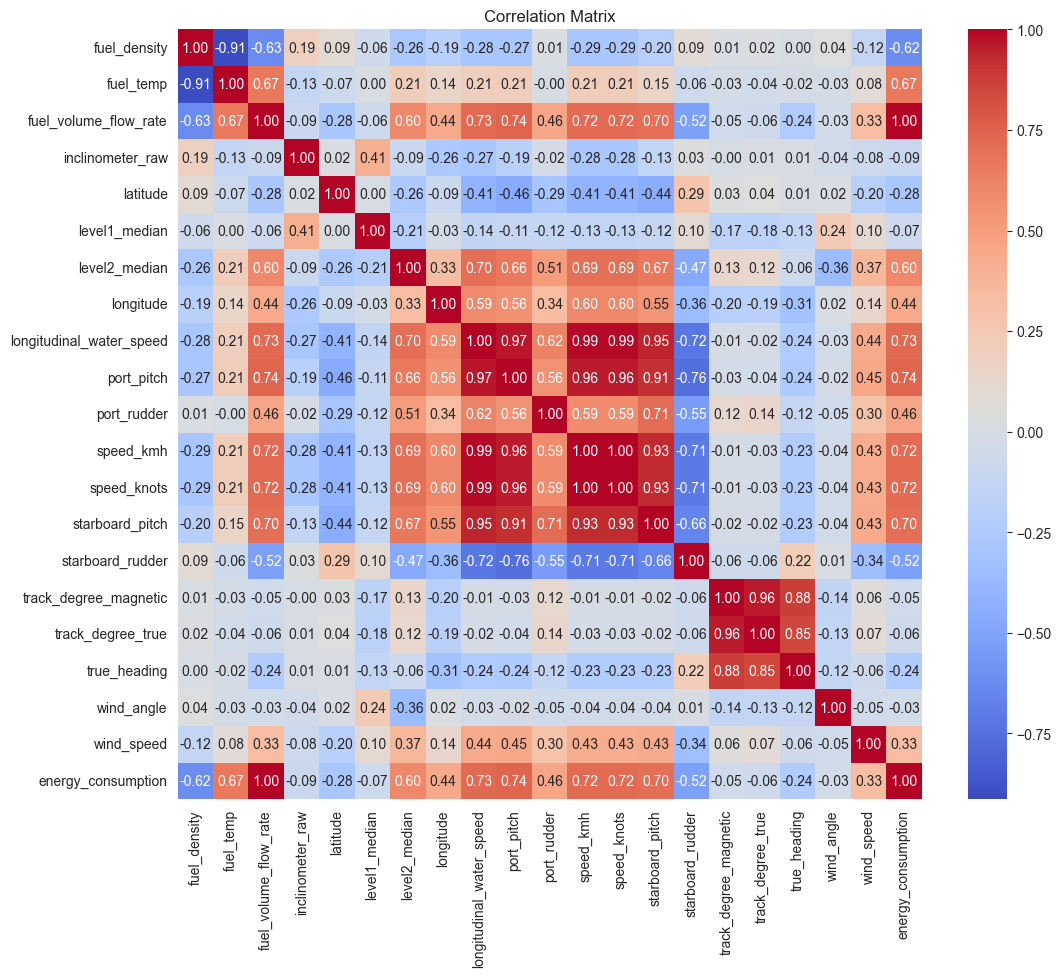

In [90]:
plt.figure(figsize=(12, 10))
sns.heatmap(ship_df_complete.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [91]:
ship_df_clean = ship_df_complete.copy()
# drop columns with lower than |0.3| correlation
ship_df_clean.drop(columns=["inclinometer_raw", "level1_median", "latitude", "track_degree_magnetic", "track_degree_true", "true_heading", "wind_angle"], inplace=True)
# drop columns with higher than |0.9| correlation
ship_df_clean.drop(columns=["fuel_volume_flow_rate"], inplace=True)

In [92]:
X = ship_df_clean.drop(columns=["energy_consumption"])
y = ship_df_clean["energy_consumption"]

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
svr_model = SVR(kernel='rbf', C=100, gamma=0.0005)
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR MSE:", mse_svr)
print("SVR R2:", r2_svr)


SVR MSE: 0.002088155425919356
SVR R2: 0.8933305667328361


In [95]:
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R2:", r2_rf)

Random Forest MSE: 0.0005077277799640855
Random Forest R2: 0.974063695704586
